In [26]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
from scipy.stats import shapiro, kstest, chisquare, norm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import math

# np.random.seed(42)  # для воспроизводимости результатов

# Генерация данных
n_samples = 200
x1 = np.random.uniform(-5,5, n_samples)
x2 = np.random.uniform(-5,5, n_samples)
x3 = np.random.uniform(-5,5, n_samples)
e = np.random.normal(0, 1, n_samples)  # случайный шум

# Рассчитываем отклик y
y = 1 + 3*x1 - 2*x2 + x3 +e

# Создаем DataFrame
data = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'y': y})


In [27]:

# Добавляем столбец с единицами для свободного члена
X = sm.add_constant(data[['x1', 'x2', 'x3']])
y = data['y']

# Строим модель
model = sm.OLS(y, X).fit()

# Выводим результаты регрессии
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     7355.
Date:                Thu, 30 Nov 2023   Prob (F-statistic):          4.29e-201
Time:                        11:36:49   Log-Likelihood:                -288.32
No. Observations:                 200   AIC:                             584.6
Df Residuals:                     196   BIC:                             597.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9955      0.073     13.591      0.0

In [28]:
lr = LinearRegression()
lr.fit(data[['x1','x2','x3']],data['y'])

LinearRegression()

In [29]:
err = y - lr.predict(data[['x1','x2','x3']])

In [30]:
ESS = sum((err)**2)
RSE = math.sqrt(ESS/(n_samples - 3 - 1)*ESS)
TSS = sum((y-np.mean(y))**2)
F_stat = ((TSS - ESS)/3)/(ESS/(n_samples - 3 - 1))
R2 = 1 - ESS/TSS
print(f'R2 = {round(R2,3)}')
print(f'F_stat = {F_stat}')
print(f'TSS = {TSS}')
print(f'RSE = {RSE}')
print(f'ESS = {ESS}')

R2 = 0.991
F_stat = 7354.5592406444175
TSS = 23766.66824787079
RSE = 14.947806505856867
ESS = 209.26929108199613


In [31]:
r2_score(lr.predict(data[['x1','x2','x3']]),y)
r2 = 0.814

In [32]:
df = pd.read_csv('data.csv',low_memory=False)
df = df.drop_duplicates()


In [33]:
#df

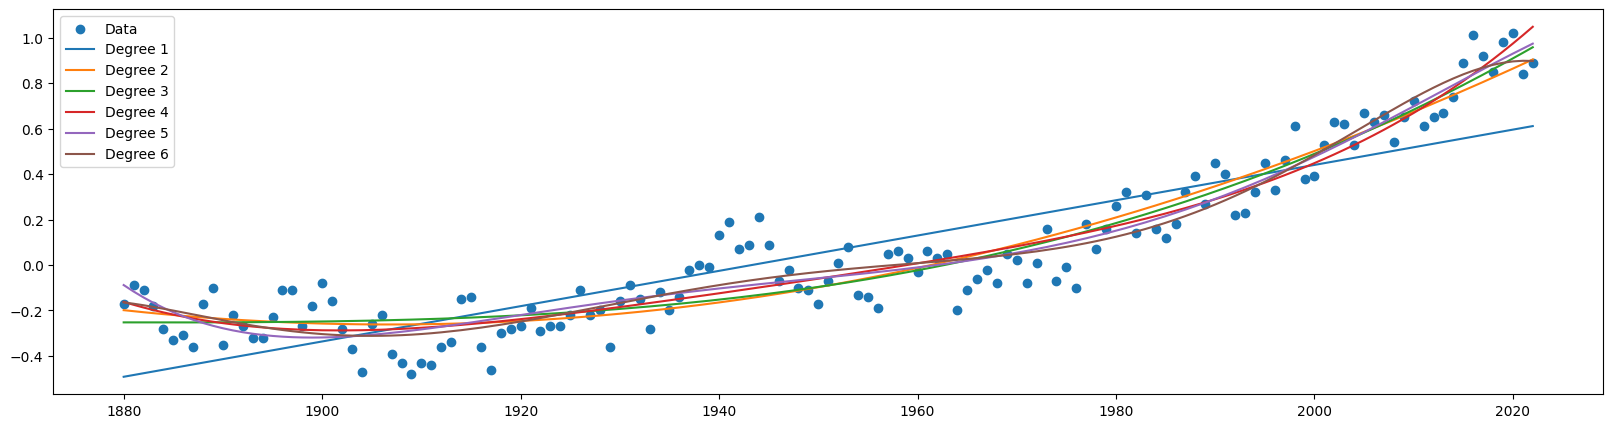

In [34]:

plt.rcParams["figure.figsize"] = (20, 5)

plt.scatter(df['Year'], df['No_Smoothing'], label='Data')


for degree in range(1, 7):
    model = np.poly1d(np.polyfit(df['Year'], df['No_Smoothing'], degree))
    
    plt.plot(df['Year'], model(df['Year']), label=f'Degree {degree}')

plt.legend()


plt.show()

In [35]:
r2_score(model(df['Year']), df['Year'])
print(r2)

0.814


In [36]:
ESS = sum(model(df['Year']) - df['Year'])

In [37]:
def select_extension(predictor, corrector, right_border):
    for i in range(right_border):
        m = np.poly1d(np.polyfit(predictor, corrector, i))
        ess = sum((m(predictor) - corrector)**2)
        print(f"ESS x^{i} ", ess)

select_extension(df['Year'], df['No_Smoothing'], 7)

ESS x^0  19.226493706293716
ESS x^1  4.519526292721364
ESS x^2  1.95632118759663
ESS x^3  1.8921050848598557
ESS x^4  1.7438309140731227
ESS x^5  1.6556419372169298
ESS x^6  1.5697936839032698
